# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.
Наша задача - построить модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

### Импортируем библиотеки

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

### Прочитаем таблицу

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


Посмотрим на размер выборки:

In [4]:
print(labels.shape)

(7591, 2)


В таблице 7591 строк и 2 столбца.

In [5]:
labels.info()
labels.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


В таблице 2 типа данных: object и int64 (название фото и возраст на этом фото).

### Построим график распределения возраста

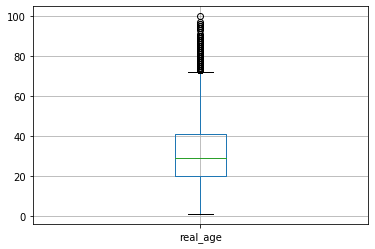

In [7]:
labels.boxplot()
plt.show()

Максимальное количество людей в выборке приходится на возраст 30 и 25 лет, далее фотограффии по возрастам распределены относительно равномерно, но людей после 75-ти лет на фотографиях мало.

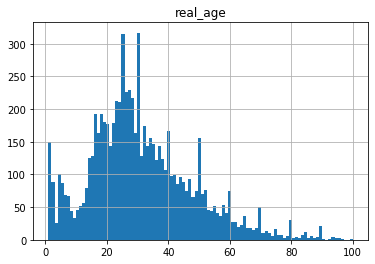

In [9]:
labels.hist(bins=100)
plt.show()

В целом на гистограмме нормальное распределение по возрасту, но есть видимые выбросы каждые 10 лет, начиная с 0 лет. Это можно отнести к выписке и юбилеям, когда фотографий больше всего. Также много фотографий детей (есть небольшой сдвиг в сторону возраста 0-7 лет), люди любят фотографировать своих детей.

### Напечатаем 10-15 фотографий

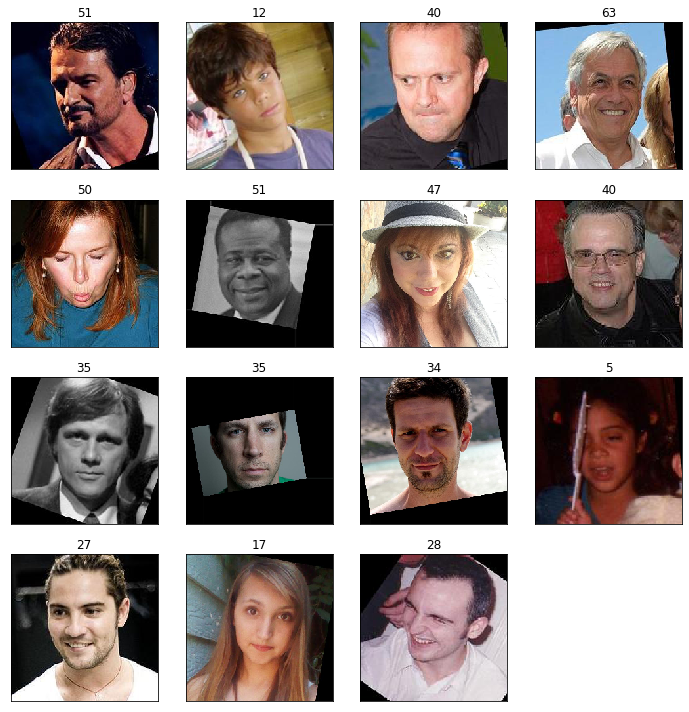

In [10]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])

    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Перед нами довольно разнообразная выборка фотографий людей разных возрастов. Но на некоторых фотографиях встречаются некоторого рода артефакты, такие как пузырь из жвачки, тёмное фото, фото в профиль, что может снизить качество модели, поэтому нужно будет сделать модель, которая учтёт все эти недочёты в изображениях, не понизив при этом качество предсказаний. Также можно заметить, что фотографии предварительно обработали, повернув их, например, на 15-20 градусов, масштабировав размеры и применив ч/б фильтр чтобы увеличить выборку.

### Вывод

У нас небольшое количество фотографий после 75 лет, огромное количество фотографий возрастом 25-30 лет, и ещё много фотографий с маленькими детьми. Есть видимые выбросы каждые 10 лет, начиная с 0 лет. Это можно отнести к выписке и юбилеям, когда фотографий больше всего. Коллекция фтографий уже была предварительно обработана (встречаются наклон фото на несколько градусов), однако в ней есть фотографии и плохого качества.

## Обучение модели

Здесь код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

labels = pd.read_csv('/datasets/faces/labels.csv')

optimizer = Adam(lr=0.0001)

def load_train(path):
    datagen = ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=False,
        validation_split=0.25,
        rescale=1/255.)

    train_datagen_flow = datagen.flow_from_dataframe(
		dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        subset='training',
        class_mode='raw',
        seed=12345)

    return train_datagen_flow
    
def load_test(path):
    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.)

    test_datagen_flow = datagen.flow_from_dataframe(
		dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        subset='validation',
        class_mode='raw',
        seed=12345)

    return test_datagen_flow
    
def create_model(input_shape):
	
	backbone = ResNet50(input_shape=(150, 150, 3), 
						weights='imagenet', 
						include_top=False)
                    
	model = Sequential()
	model.add(backbone)
	model.add(GlobalAveragePooling2D())
	model.add(Dense(1, activation='relu')) 

	model.compile(optimizer=optimizer, 
				loss='mean_absolute_error', 
				metrics=['mae'])

	return model
    
def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
			  validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2,
              shuffle=True)

    return model
    
if __name__ == "__main__":
    train_data = load_train("/datasets/faces/final_files/")
    test_data = load_test("/datasets/faces/final_files/")
    model = create_model(train_data[0].shape[1:])
    model = train_model(model, train_data, test_data)
    loss, mae = model.evaluate(test_data[0], test_data[1], verbose=2)
    print("Model mae: {:5.2f}%".format(100 * mae))

```

```

2021-10-25 16:59:21.067031: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2021-10-25 16:59:21.068774: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2021-10-25 16:59:22.344081: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-10-25 16:59:23.026497: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2021-10-25 16:59:23.026624: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-10-25 16:59:23.026667: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-10-25 16:59:23.028715: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2021-10-25 16:59:23.029096: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2021-10-25 16:59:23.031157: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2021-10-25 16:59:23.032282: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2021-10-25 16:59:23.032341: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2021-10-25 16:59:23.036723: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2021-10-25 16:59:23.037079: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2021-10-25 16:59:23.044403: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099990000 Hz
2021-10-25 16:59:23.044941: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x56e9040 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-10-25 16:59:23.044966: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-10-25 16:59:23.191779: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4cbb860 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2021-10-25 16:59:23.191824: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2021-10-25 16:59:23.194602: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2021-10-25 16:59:23.194683: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-10-25 16:59:23.194718: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-10-25 16:59:23.194764: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2021-10-25 16:59:23.194782: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2021-10-25 16:59:23.194798: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2021-10-25 16:59:23.194813: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2021-10-25 16:59:23.194824: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2021-10-25 16:59:23.199879: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2021-10-25 16:59:23.199959: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-10-25 16:59:23.525493: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-10-25 16:59:23.525546: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2021-10-25 16:59:23.525554: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2021-10-25 16:59:23.530316: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/5
2021-10-25 16:59:34.563229: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-10-25 16:59:34.863219: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 46s - loss: 11.9179 - mae: 11.9188 - val_loss: 18.9019 - val_mae: 18.8903
Epoch 2/5
178/178 - 38s - loss: 8.1450 - mae: 8.1450 - val_loss: 18.8239 - val_mae: 18.8038
Epoch 3/5
178/178 - 38s - loss: 7.1945 - mae: 7.1942 - val_loss: 16.3190 - val_mae: 16.3093
Epoch 4/5
178/178 - 38s - loss: 6.6892 - mae: 6.6896 - val_loss: 8.9158 - val_mae: 8.9224
Epoch 5/5
178/178 - 37s - loss: 6.2240 - mae: 6.2248 - val_loss: 7.0288 - val_mae: 7.0679
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 7.0288 - mae: 7.0679
Test MAE: 7.0679

```

## Анализ обученной модели

**Что мы сделали:**

1) Мы прочитали данные из csv-файла `'labels.csv'`, использовали  *ImageDataGenerator* из библиотеки *Keras* для обработки изображений, выделения валидационной выборки и добавления весов `'imagenet'`. С помощью `flow_from_dataframe()` передали модели датафрейм и репозиторий с фоторафиями. 

2) Затем выбрали архитектуру `ResNet50()`, добавили её к выбранной нами модели `Sequential()` из библиотеки *Keras*, в параметрах указали алгоритм *Adam*, функцией потерь выбрали среднюю абсолютную ошибку MAE (`loss='mean_absolute_error'`), активацией выбрали *ReLu*, т.к. имеем дело с числами и нам нужна линейная функция, на выходе у нас только 1 юнит в слое, как того требует архитектура. 

**Что мы получили:**

На 5-ти эпохах получили предсказания с ошибкой равной 7, что является довольно низкой ошибкой. 

### Вывод

Наша модель работает корректно и может предсказать с довольно высокой точностью возраст покупателя по фото.

## Вывод

Нам дана была задача построить модель, которая по фотографии определит приблизительный возраст человека. Мы построили модель, которая предсказывает возраст человека по фотографии с минимально допустимой ошибкой 7%, а значит с задачей мы справились и модель можно внедрять в бизнес.